In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from Systems.DoublePendulum import *
from Systems.Generate_Data import *
from HamiltonianNeuralNetwork.pHNN import *
from NumericalIntegration.Numerical_Integration import *
from HamiltonianNeuralNetwork.Train import *
torch.random.manual_seed(1)
np.random.seed(33)
mps_device = torch.device("mps")

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [2]:
T_max_train = 6*np.pi
nsamples_train = 100*T_max_train/6
ntraj_train = 1750#7000 #1750
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750#3000 #750
epochs = 50


batch_size = 64
lr = 1e-3

act_1 = PAU()
act_2 = nn.Softplus()

sys = DoublePendulumExternalForce()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [3]:
def H_loss_func(dudt,dudt_est):
    func = torch.nn.MSELoss()
    MSE_dudt = func(dudt_est,dudt)
    return MSE_dudt


def penalty_loss_func(model,time, lam_F=1e-4,lam_N=1e-4):
    penalty = 0
    penalty += lam_F*torch.mean(torch.abs(model.External_Force(time.reshape(-1,1)).detach()))
    penalty += lam_N*torch.mean(torch.abs(model.Get_N().detach()))

    return penalty

loss_func = loss_wrapper(H_loss_func)
penalty_func = loss_wrapper(penalty_loss_func)



In [4]:
def initial_condition():
    def sampler():
        min_norm=0.3
        max_norm=0.6
        dim=4
        while True:
            vec = np.random.randn(dim)  # Generate random vector from normal distribution
            norm = np.linalg.norm(vec)  # Compute L2 norm
            if norm == 0:
                continue  # Avoid division by zero
            else:
                break

        vec = vec / norm  # Normalize to unit vector
        scale = np.random.uniform(min_norm, max_norm)
        vec = vec * scale
        x0, y0, px0, py0 = vec[0], vec[1], vec[2], vec[3]

        return np.array([x0,y0,px0,py0]).flatten()
    return sampler()
    

In [5]:
integrator = "midpoint"

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end,t_start, dt), dudt

(u_start, u_end,t_start, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, t_start, dt), dudt

100%|██████████| 750/750 [00:09<00:00, 79.48it/s]


In [6]:
"""
Hamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)
External_Forces_est = ExternalForceNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)


model_exp = PortHamiltonianNeuralNetwork(nstates = 4, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)

optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)

trainer = Training(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp, system = sys, batch_size=batch_size,epochs = epochs)
model_exp, trainingdetails_symp = trainer.train(loss_func=loss_func,penalty_func = penalty_func)
"""

'\nHamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)\nExternal_Forces_est = ExternalForceNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)\n\n\nmodel_exp = PortHamiltonianNeuralNetwork(nstates = 4, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)\n\noptimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)\n\ntrainer = Training(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp, system = sys, batch_size=batch_size,epochs = epochs)\nmodel_exp, trainingdetails_symp = trainer.train(loss_func=loss_func,penalty_func = penalty_func)\n'

In [7]:
#model_exp,_,_ = load_model(path = "Models/DoublePendulumExternalForce/DoublePendulumExternalForce_midpoint_50epoch_PAU()_PAU()_batchsize_64_shape_torch.Size([549500, 4]).pt")

In [8]:
"""
tmax =  4*np.pi
nsamples = 100*tmax/2
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_exp[0].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))  
y, py = u_exact[0][:, 0], u_exact[0][:, 1]
ax.plot(y, py, label="Exact")
y, py = u_pred[:, 0], u_pred[:, 1]
ax.plot(y, py, label="PHNN")
ax.set_xlabel("y")
ax.set_ylabel("py")
ax.set_title("Phase Space Trajectory Explicit Midpoint" )
ax.legend()


plt.tight_layout() 
plt.show()
"""

'\ntmax =  4*np.pi\nnsamples = 100*tmax/2\ndt = tmax/nsamples\n\nnt = round(tmax / dt)\nt_sample = np.linspace(0, tmax, nt + 1)\nintegrator = "midpoint"\nntrajectories = 1\n\n(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)\n\nu_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)\n\nu_pred = u_phnn_exp[0].detach().numpy()\n\nfig, ax = plt.subplots(1, 1, figsize=(6, 5))  \ny, py = u_exact[0][:, 0], u_exact[0][:, 1]\nax.plot(y, py, label="Exact")\ny, py = u_pred[:, 0], u_pred[:, 1]\nax.plot(y, py, label="PHNN")\nax.set_xlabel("y")\nax.set_ylabel("py")\nax.set_title("Phase Space Trajectory Explicit Midpoint" )\nax.legend()\n\n\nplt.tight_layout() \nplt.show()\n'

In [9]:
integrator = "symplectic midpoint"

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s = u0s_train)
train_data = (u_start, u_end,t_start, dt), dudt

(u_start, u_end,t_start, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, t_start, dt), dudt

100%|██████████| 750/750 [01:17<00:00,  9.70it/s]


100%|██████████| 50/50 [46:22<00:00, 55.66s/it, epoch=49, loss=0.000302]


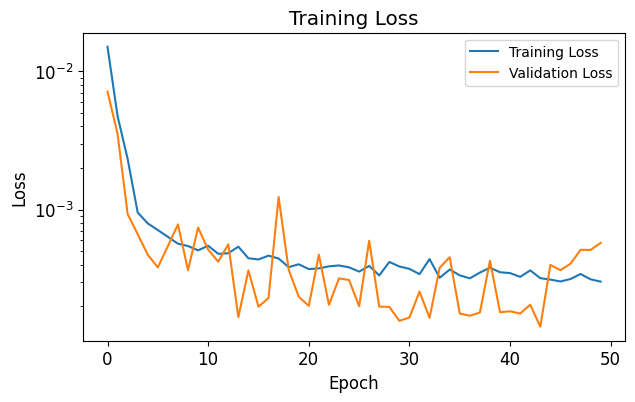

In [10]:
Hamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)
External_Forces_est = ExternalForceNeuralNetwork(nstates = 4, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)


model_symp = PortHamiltonianNeuralNetwork(nstates = 4, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)

optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)

trainer = Training(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp, system = sys, batch_size=batch_size,epochs = epochs)
model_symp, trainingdetails_symp = trainer.train(loss_func=loss_func,penalty_func = penalty_func)

In [11]:
tmax =  6*np.pi
nsamples = 100*tmax/6
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "symplectic midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_symp[0].detach().numpy()


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/HamiltonianNeuralNetwork/pHNN.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/NumericalIntegration/Numerical_Integration.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian

In [12]:
H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_pred])
C = model_symp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))

#Computed estimated Hamiltonian from values for prediction
H_nn= torch.tensor([(model_symp.Hamiltonian(torch.tensor(u))- C)for u in u_pred])

#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_pred])
    
#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - C) for u in u_exact.squeeze(0)])


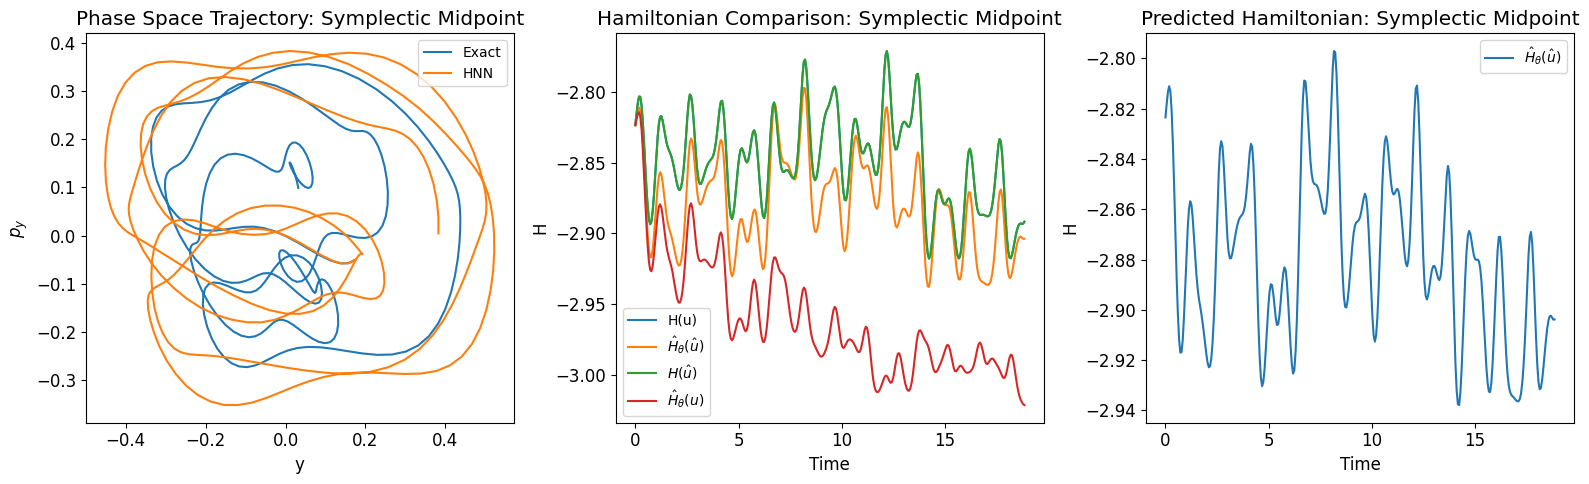

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_pred[:, 1], u_pred[:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Symplectic Midpoint" )
ax[0].legend()

t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Symplectic Midpoint")
ax[1].legend()

ax[2].plot(t, H_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Predicted Hamiltonian: Symplectic Midpoint")
ax[2].legend()
plt.tight_layout() 
plt.show()


In [14]:
t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(-1) 
external_force = model_symp.External_Force(t_tensor).detach() 

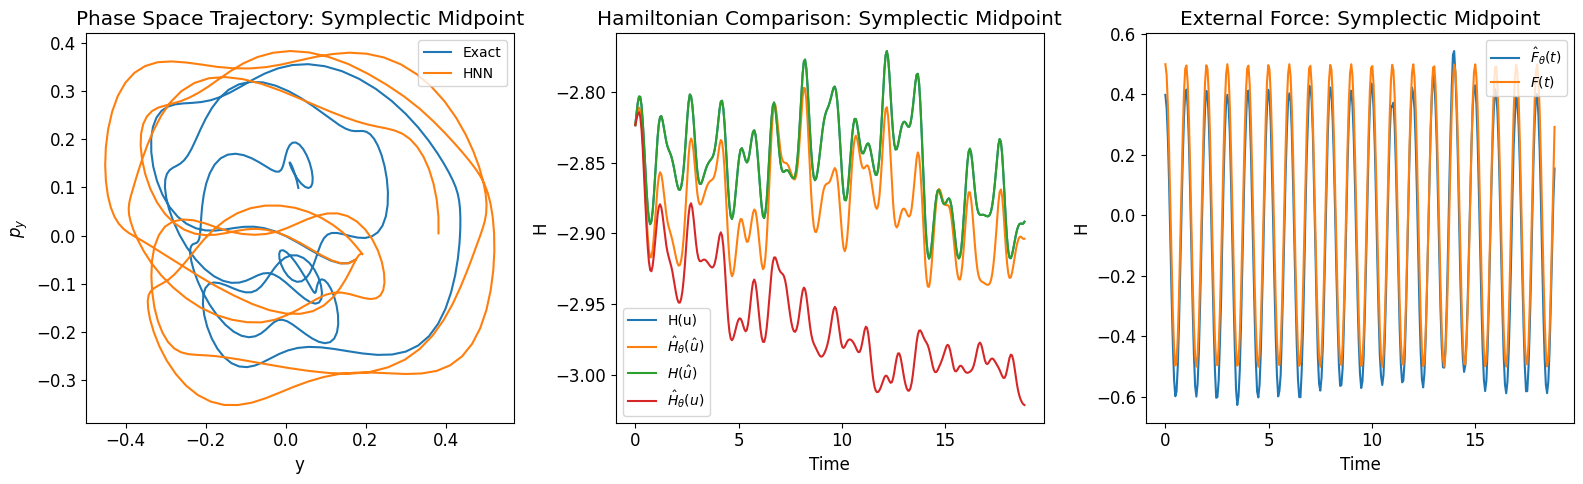

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_pred[:, 1], u_pred[:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Symplectic Midpoint" )
ax[0].legend()

t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Symplectic Midpoint")
ax[1].legend()

ax[2].plot(t, external_force[:,0], label=r"$\hat{F}_{\theta}(t)$")
ax[2].plot(t, 0.5 * np.cos(2 * np.pi * t), label=r"${F}(t)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("External Force: Symplectic Midpoint")
ax[2].legend()
plt.tight_layout() 
plt.show()


## Retraining with Fourier Basis

In [16]:
def get_optimal_period(F_model, candidates, t_vals):
    f = F_model.forward(t_vals)
    errors = ((f[t_vals] - f[t_vals + int(candidates)])**2).mean()
    return candidates[errors.argmin()]

def get_optimal_period(F_model, candidates, t_vals):
    f = F_model(t_vals).detach()  # shape [N, D]
    errors = []

    for a in candidates:
        a = a.item()
        t_shifted = t_vals + a
        mask = t_shifted <= t_vals[-1]  # ensure no overflow
        t_base = t_vals[mask]
        t_shift = t_shifted[mask]

        f_base = F_model(t_base).detach()
        f_shift = F_model(t_shift).detach()

        err = ((f_base - f_shift) ** 2).mean().item()
        errors.append(err)

    errors = torch.tensor(errors)
    return candidates[errors.argmin()]

def get_optimal_period(F_model, candidates, t_vals):
    errors = []

    for a in candidates:
        a = a.item()
        t_shifted = t_vals + a
        mask = t_shifted <= t_vals[-1]  # avoid going out of bounds

        t_base = t_vals[mask].reshape(-1, 1)
        t_shift = t_shifted[mask].reshape(-1, 1)

        f_base = F_model(t_base).detach()
        f_shift = F_model(t_shift).detach()

        err = ((f_base - f_shift) ** 2).mean().item()
        errors.append(err)

    errors = torch.tensor(errors)
    return candidates[errors.argmin()], errors



In [17]:
model_symp,_,_ = load_model("Models/DoublePendulumExternalForce/DoublePendulumExternalForce_symplectic midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt")
t = t_train#.squeeze(0)
t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(-1) 
external_force = model_symp.External_Force(t_tensor).detach() 

In [18]:
Hamiltonian_est = model_symp.Hamiltonian_est
External_Forces_est = model_symp.External_Forces_est
t = t_train
dt = t[1] - t[0]
T_max_train = t[-1].item()
min_a, max_a = 5 * dt, T_max_train / 2


t_vals = torch.tensor(np.linspace(0, T_max_train, int(nsamples_train)), dtype = torch.float32).unsqueeze(-1)
candidates = torch.tensor(np.linspace(min_a, max_a, 100), dtype = torch.float32)
External_Forces_est.Fourier = False
optimal_period = get_optimal_period(External_Forces_est, candidates, t_vals)[0]
External_Forces_est.learned_period = optimal_period
External_Forces_est.Fourier = True
model_symp_fourier = PortHamiltonianNeuralNetwork(
    nstates=4,
    S=sys.S,
    Hamiltonian_est=Hamiltonian_est,
    External_Forces_est=External_Forces_est
)



from torch.serialization import add_safe_globals


add_safe_globals([PortHamiltonianNeuralNetwork])

checkpoint = torch.load("Models/DoublePendulumExternalForce/DoublePendulumExternalForce_symplectic midpoint_50epoch_PAU()_Softplus(beta=1.0, threshold=20.0)_batchsize_64_shape_torch.Size([549500, 4]).pt", weights_only=False)
state_dict = checkpoint['model'].state_dict()
model_symp_fourier.load_state_dict(state_dict)



<All keys matched successfully>

### Retraining Model

100%|██████████| 50/50 [50:46<00:00, 60.93s/it, epoch=49, loss=0.00488]


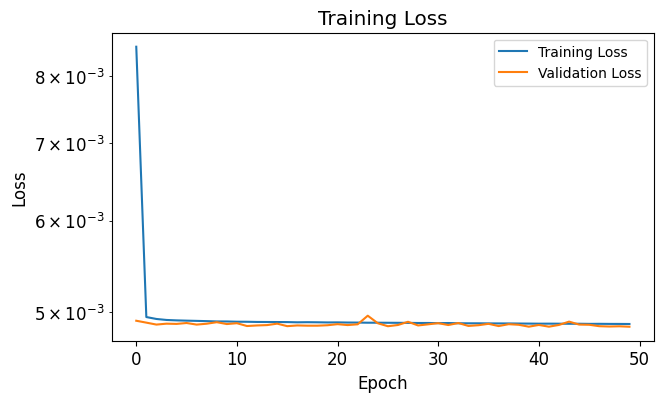

In [19]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_symp_fourier.parameters()), lr=lr)

trainer = Training(
    model=model_symp_fourier,
    integrator=integrator,
    train_data=train_data,
    val_data=val_data,
    optimizer=optimizer,
    system=sys,
    batch_size=batch_size,
    epochs=epochs
)

model_symp_fourier, new_training_details = trainer.train(loss_func=loss_func, penalty_func=penalty_func)


## Predicting with re-trained model

In [25]:
tmax =  12*np.pi
nsamples = 100*tmax/12
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "symplectic midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_symp[0].detach().numpy()

100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian is singular, stopping.
Jacobian

In [26]:
H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_pred])
C = model_symp.Hamiltonian(torch.tensor(u0s, dtype = torch.float32))- sys.Hamiltonian(u0s.squeeze(0))

#Computed estimated Hamiltonian from values for prediction
H_nn= torch.tensor([(model_symp.Hamiltonian(torch.tensor(u))- C)for u in u_pred])

#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_pred])
    
#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - C) for u in u_exact.squeeze(0)])


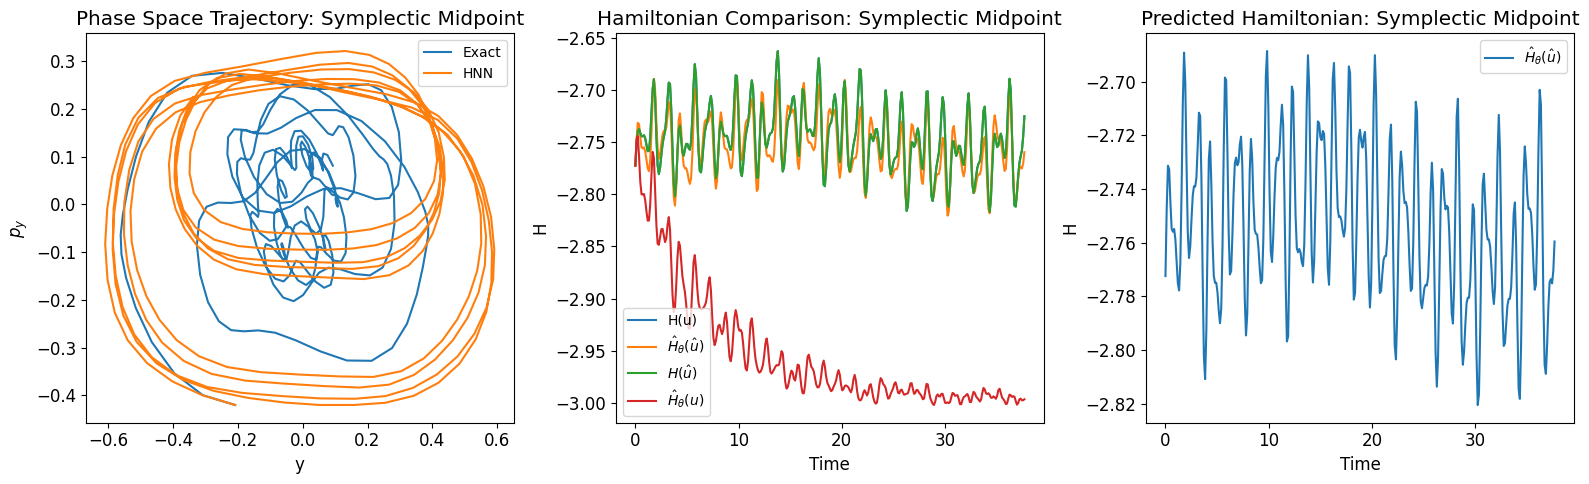

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_pred[:, 1], u_pred[:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Symplectic Midpoint" )
ax[0].legend()

t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
ax[1].plot(t, H_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Symplectic Midpoint")
ax[1].legend()

ax[2].plot(t, H_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("Predicted Hamiltonian: Symplectic Midpoint")
ax[2].legend()
plt.tight_layout() 
plt.show()


In [28]:
t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(-1) 
external_force = model_symp.External_Force(t_tensor).detach() 

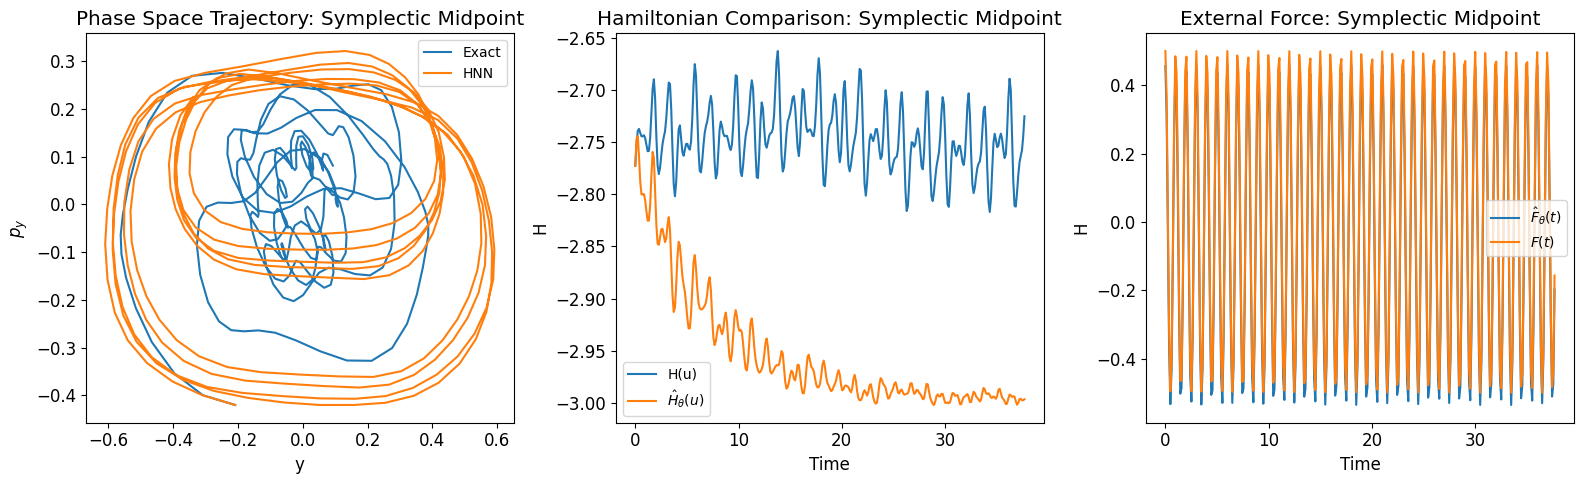

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_pred[:, 1], u_pred[:, 3]
ax[0].plot(y, py, label="HNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel(r"$p_y$")
ax[0].set_title("Phase Space Trajectory: Symplectic Midpoint" )
ax[0].legend()

t = t_sample.squeeze(0)

ax[1].plot(t, H_exact, label="H(u)")
#ax[1].plot(t, H_nn, label=r"$\hat{H}_{\theta}(\hat u)$")
#ax[1].plot(t, H_exact_pred, label=r"$H(\hat u)$")
ax[1].plot(t, H_nn_exact, label=r"$\hat{H}_{\theta}(u)$")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison: Symplectic Midpoint")
ax[1].legend()

ax[2].plot(t, external_force[:,0], label=r"$\hat{F}_{\theta}(t)$")
ax[2].plot(t, 0.5 * np.cos(2 * np.pi * t), label=r"${F}(t)$")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("H")
ax[2].set_title("External Force: Symplectic Midpoint")
ax[2].legend()
plt.tight_layout() 
plt.show()
